# Pytorch Custom Dataset
https://www.learnpytorch.io/04_pytorch_custom_datasets/

## 1. Get the Data 

In [1]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

data\pizza_steak_sushi directory exists.


## 2. Data Preparation 

The goal will be to take this data storage structure and turn it into a dataset usable with PyTorch.

In [2]:
import os 
def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    Args:
        dir_path (str or pathlib.Path): target directory
    
    Returns:
        A print out of:
        number of subdiretories in dir_path
        number of images (files) in each subdirectory
        name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

         


In [3]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [4]:
# Setup train and testing path 
train_dir = image_path/"train"
test_dir = image_path/"test"

### 2.1 Visualize an image 

1. Get all of the image paths using pathlib.Path.glob() to find all of the files ending in .jpg.
2. Pick a random image path using Python's random.choice().
3. Get the image class name using pathlib.Path.parent.stem.
4. And since we're working with images, we'll open the random image path using PIL.Image.open() (PIL stands for Python Image Library).
5. We'll then show the image and print some metadata.

data\pizza_steak_sushi\test\pizza
Random image path: data\pizza_steak_sushi\test\pizza\2124579.jpg
Image class: pizza
Image height: 384
Image width: 512


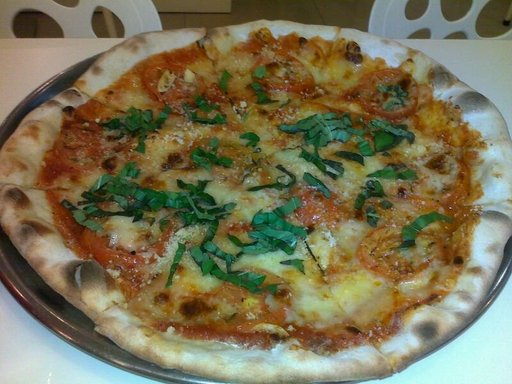

In [5]:
import random 
from PIL import Image 

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(random_image_path.parent)


# 4. Open image
img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

We can do the same with `matplotlib.pyplot.imshow()`, except we have to convert the image to a NumPy array first.

(np.float64(-0.5), np.float64(511.5), np.float64(383.5), np.float64(-0.5))

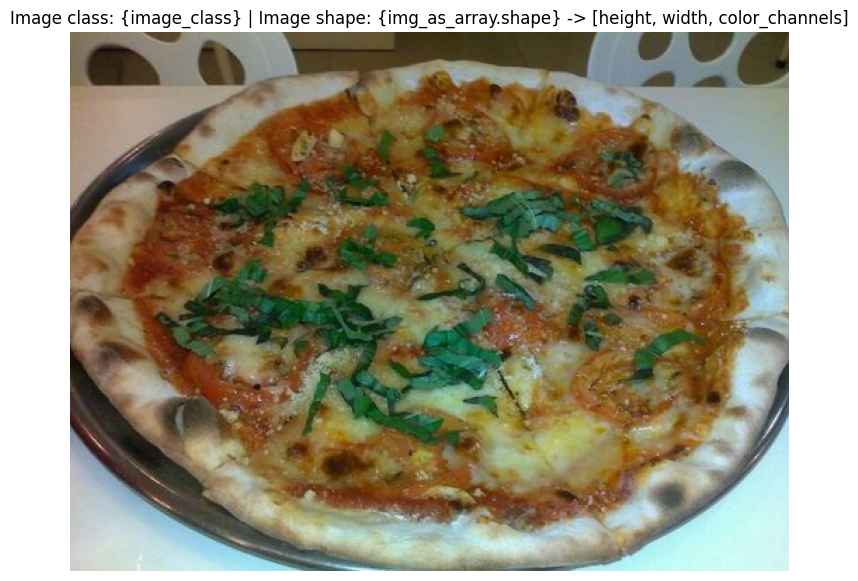

In [6]:
import numpy as np 
import matplotlib.pyplot as plt 

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title("Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

## 3. Transforming Data

1. Turn it into tensors (numerical representations of our images).
2. Turn it into a torch.utils.data.Dataset and subsequently a torch.utils.data.DataLoader, we'll call these Dataset and DataLoader for short.

In [7]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

We've got folders of images but before we can use them with PyTorch, we need to convert them into tensors.

One of the ways we can do this is by using the `torchvision.transforms` module.

`torchvision.transforms` contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for data augmentation (the practice of altering data to make it harder for a model to learn, we'll see this later on) purposes .

To get experience with `torchvision.transforms`, let's write a series of transform steps that:

1. Resize the images using `transforms.Resize()` (from about 512x512 to 64x64, the same shape as the images on the CNN Explainer website).
2. Flip our images randomly on the horizontal using `transforms.RandomHorizontalFlip()` (this could be considered a form of data augmentation because it will artificially change our image data).
3. Turn our images from a PIL image to a PyTorch tensor using `transforms.ToTensor()`.


We can compile all of these steps using `torchvision.transforms.Compose()`.

1. `transforms.Resize(size=(64,64))`

* Fungsi: ubah ukuran semua gambar jadi 64×64 pixel.

* Kenapa harus resize?
 
    * Consistency: Model CNN butuh input dengan ukuran tetap. Kalau ada gambar 32×32 dan ada 128×128, model bakal error.

    * Efisiensi: Gambar gede → butuh komputasi lebih. Resize bisa mempercepat training.

    * Trade-off: gambar kecil → informasi detail berkurang, tapi training lebih cepat.

👉 Contoh: kalau FashionMNIST (28×28) diresize jadi 64×64, kita kasih lebih banyak pixel ke model untuk belajar pola.

2. `transforms.RandomHorizontalFlip(p=0.5)`

* Fungsi: membalik gambar secara horizontal (kiri ↔ kanan).
 
* p=0.5 artinya: ada 50% kemungkinan gambar dibalik, 50% tetap sama.
 
* Kenapa dipakai?
 
    * Augmentasi data: bikin variasi gambar baru tanpa nambah dataset asli.

    * Cegah overfitting: model nggak cuma hafal posisi objek, tapi ngerti polanya.

    * Contoh real: kucing yang menghadap kiri dan kucing menghadap kanan itu tetap kucing → model harus bisa mengenali keduanya.

Kalau p=1.0 → semua gambar selalu dibalik.
Kalau p=0.0 → tidak ada gambar yang dibalik (efeknya sama kayak nggak dipakai).

In [8]:
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size = (64,64)),
    # flip the images randomly on horizontal 
    transforms.RandomHorizontalFlip(p = 0.5) , # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor()]
)

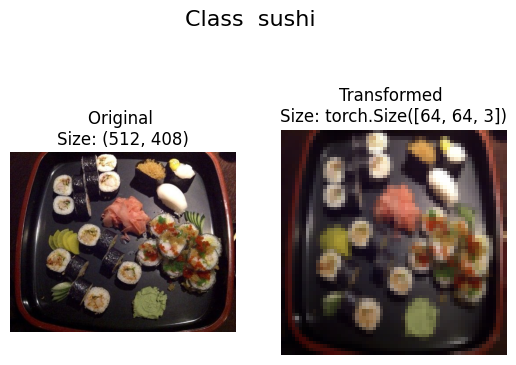

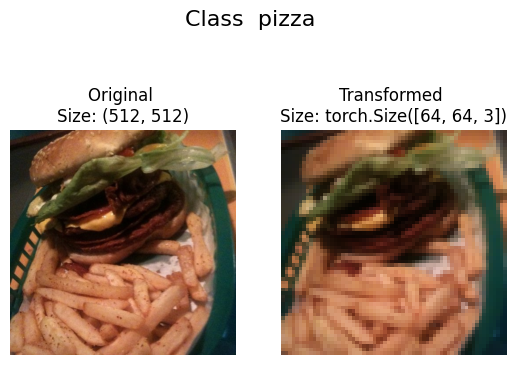

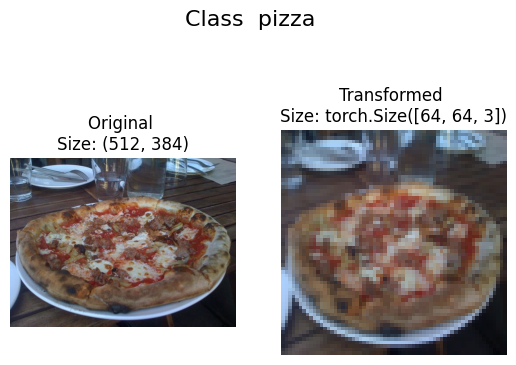

In [9]:
def plot_transformed_images(image_path, transforms, n =3, seed = 42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_path, k= n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")
            
            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            
            transformed_image = transforms(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
            
            fig.suptitle(f"Class  {image_path.parent.stem}", fontsize=16)
            
plot_transformed_images(image_path_list,data_transform,n = 3)
    

## Option 1: Loading Image Data Using `ImageFolder`

Alright, time to turn our image data into a `Dataset` capable of being used with PyTorch.

Since our data is in standard image classification format, we can use the class `torchvision.datasets.ImageFolder`.

Where we can pass it the file path of a target image directory as well as a series of transforms we'd like to perform on our images.

Let's test it out on our data folders `train_dir` and `test_dir` passing in `transform=data_transform` to turn our images into tensors.

In [10]:
from torchvision import datasets 
train_data = datasets.ImageFolder(root = train_dir,  # target folder of images
                                  transform= data_transform, # transforms to perform on data (images)
                                  target_transform= None) # transforms to perform on labels (if necessary)
test_data  = datasets.ImageFolder(root = test_dir,
                                  transform= data_transform)

print(f"Train data:\n{train_data}\nTest Data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test Data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [11]:
class_name = train_data.classes 
class_name 

['pizza', 'steak', 'sushi']

In [12]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [13]:
# Check the lengths
len(train_data), len(test_data)

(225, 75)

In [14]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01


Our images are now in the form of a tensor (with shape `[3, 64, 64]`) and the labels are in the form of an integer relating to a specific class (as referenced by the `class_to_idx` attribute).

How about we plot a single image tensor using `matplotlib`?

We'll first have to to permute (rearrange the order of its dimensions) so it's compatible.

Right now our image dimensions are in the format CHW (color channels, height, width) but `matplotlib` prefers `HWC` (height, width, color channels).

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


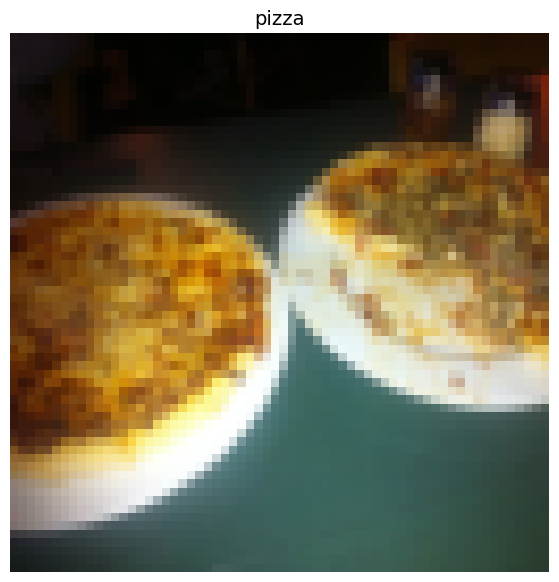

In [15]:
# Rearrange the order of dimensions

img_permute = img.permute(1,2,0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image 
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_name[label], fontsize = 14);



### 4.1 Turn loaded images into DataLoader's

We've got our images as PyTorch `Dataset`'s but now let's turn them into `DataLoader`'s.

We'll do so using `torch.utils.data.DataLoader`.

Turning our `Dataset`'s into `DataLoader`'s makes them iterable so a model can go through and learn the relationships between samples and targets (features and labels).

To keep things simple, we'll use a `batch_size=1` and `num_workers=1`.

What's `num_workers`?

Good question.

It defines how many subprocesses will be created to load your data.

Think of it like this, the higher value `num_workers` is set to, the more compute power PyTorch will use to load your data.

Personally, I usually set it to the total number of CPUs on my machine via Python's `os.cpu_count()`

This ensures the `DataLoader` recruits as many cores as possible to load data.

In [16]:
# Turn train and test Datasets into DataLoaders

from torch.utils.data import DataLoader 

train_dataloader = DataLoader(dataset= train_data,
                              batch_size= 1,
                              num_workers=1,
                              shuffle= True )

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle= True)

train_dataloader, test_dataloader



(<torch.utils.data.dataloader.DataLoader at 0x1b60735a120>,
 <torch.utils.data.dataloader.DataLoader at 0x1b607861d10>)

In [17]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 5. Option 2: Loading Image Data with a Custom Dataset


Look the book


### 5.1 Creating a helper function to get class names
Let's write a helper function capable of creating a list of class names and a dictionary of class names and their indexes given a directory path.

To do so, we'll:

1. Get the class names using os.scandir() to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dictionary of numerical labels, one for each class.

Let's see a small example of step 1 before we write the full function.


## 6. Data Augmentation

We've seen a couple of transforms on our data already but there's plenty more.

You can see them all in the `torchvision.transforms` documentation.

The purpose of tranforms is to alter your images in some way.

That may be turning your images into a tensor (as we've seen before).

Or cropping it or randomly erasing a portion or randomly rotating them.

Doing these kinds of transforms is often referred to as **data augmentation**.

**Data augmentation** is the process of altering your data in such a way that you artificially increase the diversity of your training set.

Training a model on this artificially altered dataset hopefully results in a model that is capable of better generalization (the patterns it learns are more robust to future unseen examples).

You can see many different examples of data augmentation performed on images using `torchvision.transform`s in PyTorch's Illustration of Transforms example.link (https://docs.pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html)

But let's try one out ourselves.



Machine learning is all about harnessing the power of randomness and research shows that random transforms (like `transforms.RandAugment()` and `transforms.TrivialAugmentWide()`) generally perform better than hand-picked transforms.

TrivialAugment was one of the ingredients used in a recent state of the art training upgrade to various PyTorch vision models.

How about we test it out on some of our own images?

The main parameter to pay attention to in `transforms.TrivialAugmentWide()` is `num_magnitude_bins=31`.

It defines how much of a range an intensity value will be picked to apply a certain transform, 0 being no range and 31 being maximum range (highest chance for highest intensity).

We can incorporate `transforms.TrivialAugmentWide()` into `transforms.Compose()`.

In [18]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense 
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

Note: You usually don't perform data augmentation on the test set. The idea of data augmentation is to to artificially increase the diversity of the training set to better predict on the testing set.

However, you do need to make sure your test set images are transformed to tensors. We size the test images to the same size as our training images too, however, inference can be done on different size images if necessary (though this may alter performance).

Beautiful, now we've got a training transform (with data augmentation) and test transform (without data augmentation).

Let's test our data augmentation out!

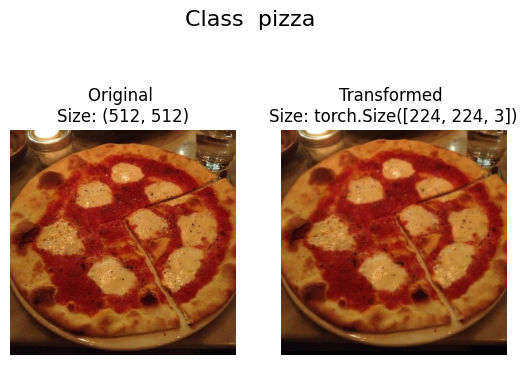

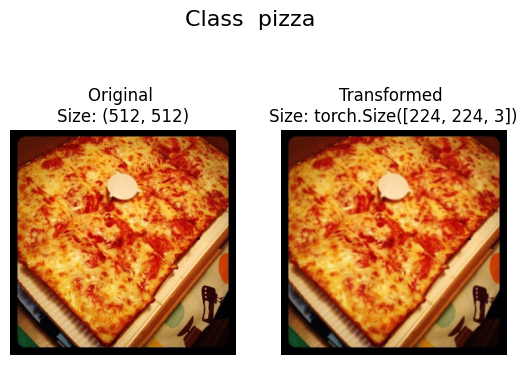

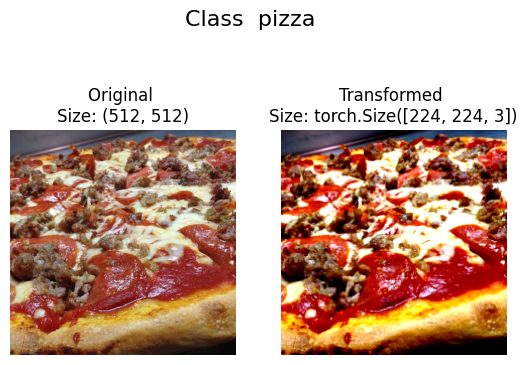

In [19]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_path_list,
    train_transforms,
    n = 3,
    seed = None
)

## 7. Model 0: TinyVGG without data augmentation

Alright, we've seen how to turn our data from images in folders to transformed tensors.

Now let's construct a computer vision model to see if we can classify if an image is of pizza, steak or sushi.

To begin, we'll start with a simple transform, only resizing the images to (64, 64) and turning them into tensors.

### 7.1 Creating transforms and loading data for model 0

In [20]:
# Create simple transform 
simple_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [21]:
int(os.cpu_count()/2)

6


Excellent, now we've got a simple transform, let's:

1. Load the data, turning each of our training and test folders first into a Dataset with `torchvision.datasets.ImageFolder()`
2. Then into a `DataLoader` using `torch.utils.data.DataLoader()`.
We'll set the `batch_size=32` and `num_workers` to as many CPUs on our machine (this will depend on what machine you're using).

In [22]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(train_dir, simple_transform)
test_data_simple = datasets.ImageFolder(test_dir, simple_transform)

# 2. Turn data into DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = int(os.cpu_count()/2)

print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple,
                                     batch_size= BATCH_SIZE,
                                     shuffle= True,
                                     num_workers= NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 6 workers.


(<torch.utils.data.dataloader.DataLoader at 0x1b6077c0550>,
 <torch.utils.data.dataloader.DataLoader at 0x1b607313950>)

In notebook 03, we used the TinyVGG model from the CNN Explainer website.

Let's recreate the same model, except this time we'll be using color images instead of grayscale (in_channels=3 instead of in_channels=1 for RGB pixels).

In [23]:
import torch.nn as nn 
device = "cuda"

class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

Note: One of the ways to speed up deep learning models computing on a GPU is to leverage operator fusion.

This means in the `forward()` method in our model above, instead of calling a layer block and reassigning `x` every time, we call each block in succession (see the final line of the `forward()` method in the model above for an e`x`ample).

This saves the time spent reassigning `x` (memory heavy) and focuses on only computing on `x`.

See Making Deep Learning Go Brrrr From First Principles by Horace He for more ways on how to speed up machine learning models.


https://horace.io/brrr_intro.html

### 7.3 Try a forward pass on a single image (to test the model)

A good way to test a model is to do a forward pass on a single piece of data.

It's also handy way to test the input and output shapes of our different layers.

To do a forward pass on a single image, let's:

1. Get a batch of images and labels from the DataLoader.
2. Get a single image from the batch and unsqueeze() the image so it has a batch size of 1 (so its shape fits the model).
3. Perform inference on a single image (making sure to send the image to the target device).
4. Print out what's happening and convert the model's raw output logits to prediction probabilities with torch.softmax() (since we're working with multi-class data) and convert the prediction probabilities to prediction labels with torch.argmax().

In [24]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim = 0 ), label_batch[0]
print(f"Single image shape: {img_single.shape}")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])
Output logits:
tensor([[0.0578, 0.0634, 0.0351]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3352, 0.3371, 0.3277]], device='cuda:0')

Output prediction label:
tensor([1], device='cuda:0')

Actual label:
2


## 7.4 Use `torchinfo` to get an idea of the shapes going through our model

Printing out our model with `print(model)` gives us an idea of what's going on with our model.

And we can print out the shapes of our data throughout the `forward()` method.

However, a helpful way to get information from our model is to use `torchinfo`.

`torchinfo` comes with a `summary()` method that takes a PyTorch model as well as an `input_shape` and returns what happens as a tensor moves through your model.

Note: If you're using Google Colab, you'll need to install torchinfo

In [25]:
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size 

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia


Nice!

The output of `torchinfo.summary()` gives us a whole bunch of information about our model.

Such as `Total params`, the total number of parameters in our model, the `Estimated Total Size (MB)` which is the size of our model.

You can also see the change in input and output shapes as data of a certain input_size moves through our model.

Right now, our parameter numbers and total model size is low.

This because we're starting with a small model.

And if we need to increase its size later, we can.

### 7.5 Create train & test loop functions

We've got data and we've got a model.

Now let's make some training and test loop functions to train our model on the training data and evaluate our model on the testing data.

And to make sure we can use these the training and testing loops again, we'll functionize them.

Specifically, we're going to make three functions:

1. `train_step()` - takes in a model, a DataLoader, a loss function and an optimizer and trains the model on the DataLoader.
2. `test_step()` - takes in a model, a DataLoader and a loss function and evaluates the model on the DataLoader.
3. `train()` - performs 1. and 2. together for a given number of epochs and returns a results dictionary.

In [26]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [27]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

Now we need a way to put our `train_step()` and `test_step()` functions together.

To do so, we'll package them up in a `train()` function.

This function will train the model as well as evaluate it.

Specificially, it'll:

1. Take in a model, a `DataLoader` for training and test sets, an optimizer, a loss function and how many epochs to perform each train and test step for.
2. Create an empty results dictionary for `train_loss`, `train_acc`, `test_loss` and `test_acc` values (we can fill this up as training goes on).
3. Loop through the training and test step functions for a number of epochs.
4. Print out what's happening at the end of each epoch.
5. Update the empty results dictionary with the updated metrics each epoch.
6. Return the filled

To keep track of the number of epochs we've been through, let's import `tqdm `from `tqdm.auto` (tqdm is one of the most popular progress bar libraries for Python and tqdm.auto automatically decides what kind of progress bar is best for your computing environment, e.g. Jupyter Notebook vs. Python script).

In [28]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

### 7.7 Train and Evaluate Model 0

Alright, alright, alright we've got all of the ingredients we need to train and evaluate our model.

Time to put our `TinyVGG` model, `DataLoader`'s and `train()` function together to see if we can build a model capable of discerning between pizza, steak and sushi!

Let's recreate `model_0` (we don't need to but we will for completeness) then call our `train()` function passing in the necessary parameters.

To keep our experiments quick, we'll train our model for **5 epochs** (though you could increase this if you want).

As for an **optimizer** and **loss function**, we'll use `torch.nn.CrossEntropyLoss()` (since we're working with multi-class classification data) and `torch.optim.Adam()` with a learning rate of 1e-3 respectively.

To see how long things take, we'll import Python's `timeit.default_timer()` method to calculate the training time.

In [29]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# set num of epochs
NUM_EPOCHS = 10 

# Recreate an instance of TinyVGG
model_0 = TinyVGG(3,10, output_shape= len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(), lr = 0.01)

# start the timer 
from timeit import default_timer as timer 
start_time = timer()

model_0_result = train(model_0, 
                       train_dataloader= train_dataloader_simple,
                       test_dataloader= test_dataloader_simple,
                       optimizer= optimizer,
                       loss_fn= loss_fn,
                       epochs= NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2180 | train_acc: 0.2500 | test_loss: 1.1973 | test_acc: 0.1979
Epoch: 2 | train_loss: 1.0989 | train_acc: 0.4141 | test_loss: 1.1055 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1014 | train_acc: 0.2930 | test_loss: 1.1091 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0940 | train_acc: 0.4141 | test_loss: 1.1126 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0996 | train_acc: 0.2930 | test_loss: 1.1190 | test_acc: 0.1979
Epoch: 6 | train_loss: 1.0933 | train_acc: 0.4141 | test_loss: 1.1236 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1094 | train_acc: 0.2930 | test_loss: 1.1272 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1072 | train_acc: 0.2930 | test_loss: 1.1206 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.1032 | train_acc: 0.2930 | test_loss: 1.1106 | test_acc: 0.1979
Epoch: 10 | train_loss: 1.0993 | train_acc: 0.2930 | test_loss: 1.1002 | test_acc: 0.1979
Total training time: 103.229 seconds


In [30]:
# Check the model_0_results keys
model_0_result.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [31]:
from typing import Dict, List
import matplotlib.pyplot as plt

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

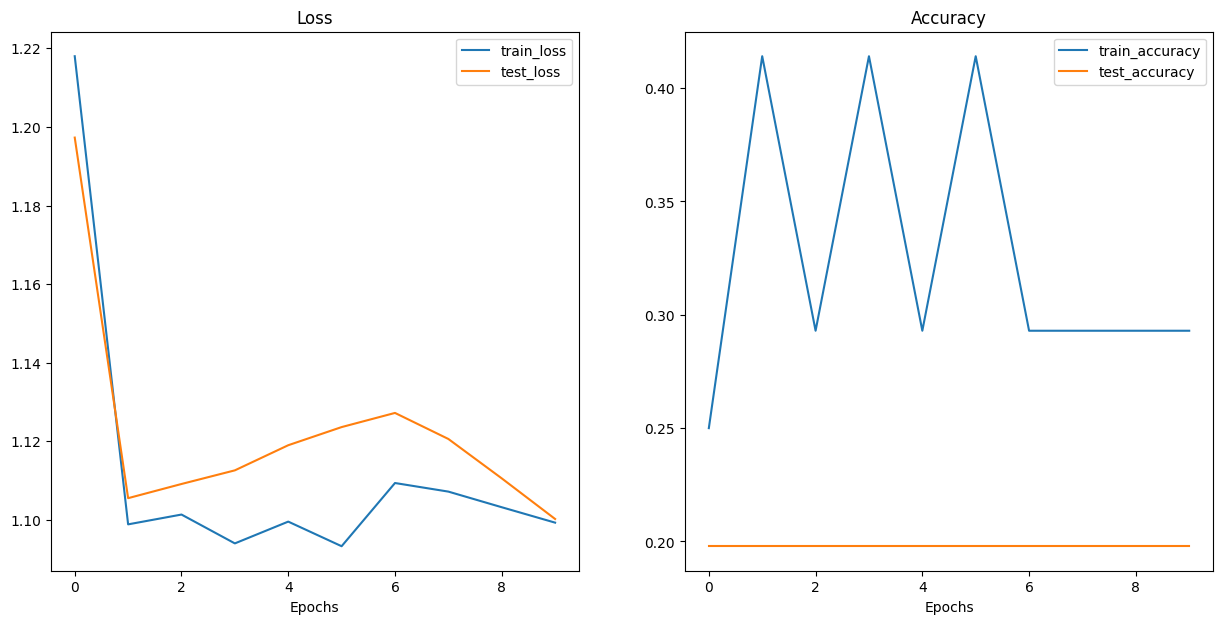

In [32]:
plot_loss_curves(model_0_result)

## 9. Model 1: TinyVGG with Data Augmentation

Time to try out another model!

This time, let's load in the data and use data augmentation to see if it improves our results in anyway.

First, we'll compose a training transform to include `transforms.TrivialAugmentWide()` as well as resize and turn our images into tensors.

We'll do the same for a testing transform except without the data augmentation.

### 9.1 Create transform with data augmentation

In [33]:
# Create training transform with TrivialAugment
train_transforms_trivial_augment  = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor() 
])

# Create testing transform (no data augmentation)
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

### 9.2 Create train and test Dataset's and DataLoader's

In [34]:
train_data_augmented = datasets.ImageFolder(train_dir, train_transforms_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, test_transforms)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [35]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1b60746dcd0>,
 <torch.utils.data.dataloader.DataLoader at 0x1b607861d10>)

### 9.3 Construct and train Model 1

In [36]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

Time to train!



* Train for 10 epochs.
* Use train_dataloader=train_dataloader_augmented as the training data in train().
* Use torch.nn.CrossEntropyLoss() as the loss function (since we're working with multi-class classification).
* Use torch.optim.Adam() with lr=0.001 as the learning rate as the optimizer.

In [37]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_1
model_1_results = train(model=model_1, 
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1074 | train_acc: 0.2500 | test_loss: 1.1059 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0790 | train_acc: 0.4258 | test_loss: 1.1385 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0802 | train_acc: 0.4258 | test_loss: 1.1695 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1286 | train_acc: 0.3047 | test_loss: 1.1619 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0885 | train_acc: 0.4258 | test_loss: 1.1476 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.0968 | train_acc: 0.3047 | test_loss: 1.1482 | test_acc: 0.2604
Epoch: 7 | train_loss: 1.0915 | train_acc: 0.4531 | test_loss: 1.1513 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1005 | train_acc: 0.2930 | test_loss: 1.1575 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.1201 | train_acc: 0.2930 | test_loss: 1.1449 | test_acc: 0.2708
Epoch: 10 | train_loss: 1.0880 | train_acc: 0.4883 | test_loss: 1.0996 | test_acc: 0.2812
Total training time: 156.905 seconds


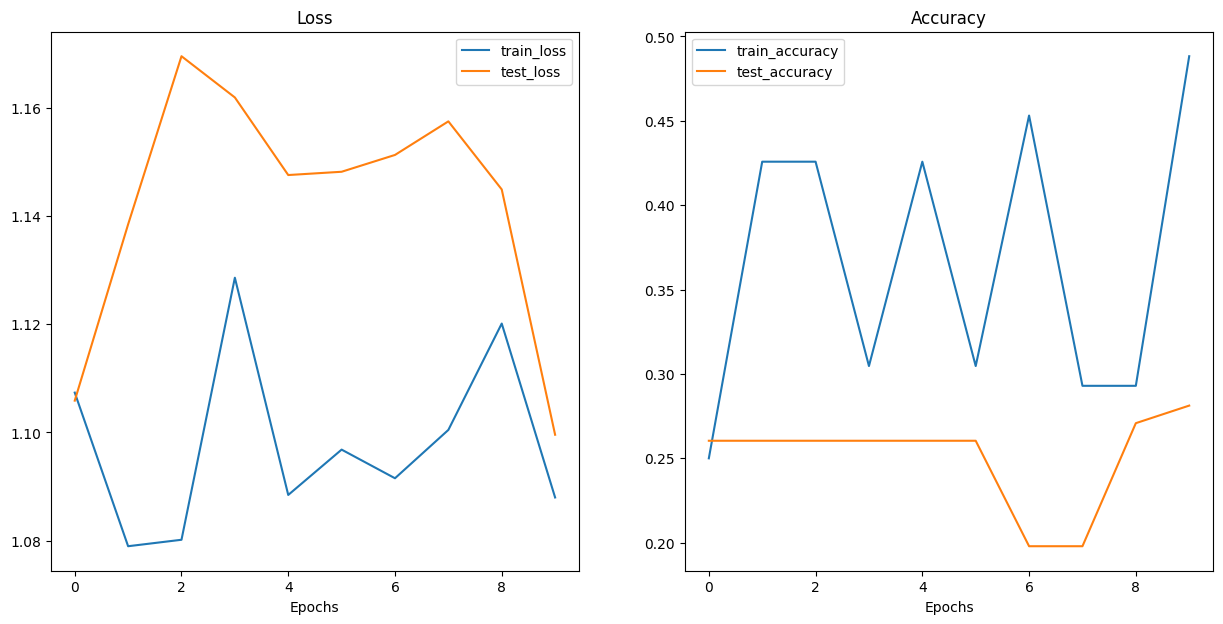

In [38]:
plot_loss_curves(model_1_results)

## 10. Compare the result 

In [40]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_result)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.218000,0.250000,1.197295,0.197917
1,1.098857,0.414062,1.105525,0.197917
2,1.101355,0.292969,1.109133,0.197917
3,1.094013,0.414062,1.112604,0.197917
4,1.099557,0.292969,1.118999,0.197917
5,1.093294,0.414062,1.123615,0.197917
6,1.109380,0.292969,1.127217,0.197917
7,1.107194,0.292969,1.120591,0.197917
8,1.103218,0.292969,1.110565,0.197917
9,1.099295,0.292969,1.100226,0.197917


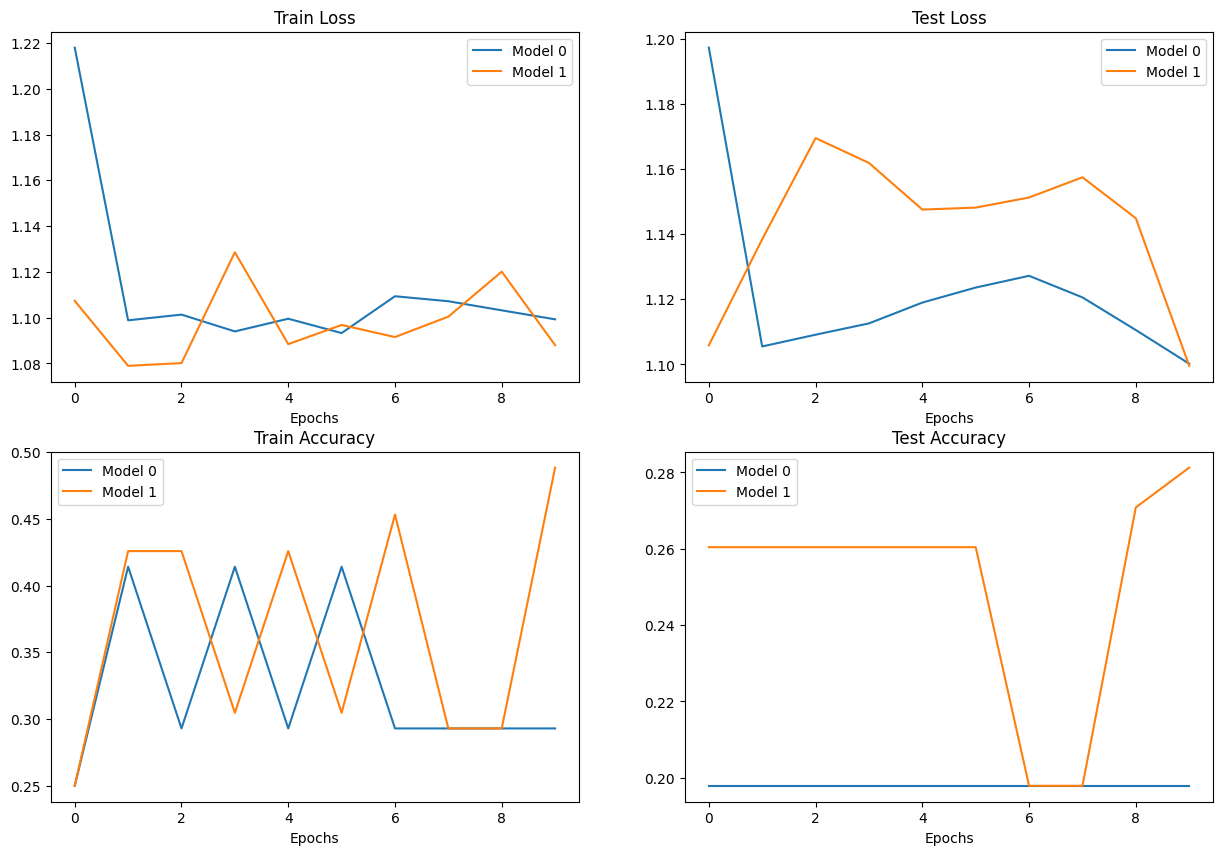

In [41]:
# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

## 11. Make a prediction on a custom image

In [42]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

### 11.1 Loading in a custom image with PyTorch

Time to load it in.

PyTorch's `torchvision` has several input and output ("IO" or "io" for short) methods for reading and writing images and video in `torchvision.io.`

Since we want to load in an image, we'll use `torchvision.io.read_image()`.

This method will read a JPEG or PNG image and turn it into a 3 dimensional RGB or grayscale `torch.Tensor` with values of datatype uint8 in range [0, 255].

In [43]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

In [44]:
# Try to make a prediction on image in uint8 format (this will error)
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_uint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same